# 42 Draping LineStrings over Digital Elevation Model in PyVista

When displaying LineString data in combination with a Digital Elevation Model, it is desired to map LineStrings representing elements such as roads on top of the Digital Elevation Model instead of above or below. Here it is shown how to do that with GemGIS.

<img src="../images/tutorial42_cover.png">

## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

In [1]:
import gemgis as gg

file_path ='data/42_draping_linestrings_over_dem_in_pyvista/'

In [2]:
gg.download_gemgis_data.download_tutorial_data(filename="42_draping_linestrings_over_dem_in_pyvista.zip", dirpath=file_path)

## Loading Mesh and Vector Data

The loaded digital elevation model will be used under Datenlizenz Deutschland – Zero – Version 2.0. It was obtained from the WCS Service https://www.wcs.nrw.de/geobasis/wcs_nw_dgm. 

In [3]:
import pyvista as pv
import rasterio

raster = rasterio.open(file_path + 'DEM50_EPSG_4647_clipped.tif')

topo = pv.read(file_path + 'topo.vtk')
topo

StructuredGrid (0x1c816bec6a0)
  N Cells:      4923561
  N Points:     4928000
  X Bounds:     3.228e+07, 3.239e+07
  Y Bounds:     5.650e+06, 5.760e+06
  Z Bounds:     -9.627e+01, 4.243e+02
  Dimensions:   2200, 2240, 1
  N Arrays:     1

C:\Users\ale93371\Anaconda3\envs\pygeomechanical\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


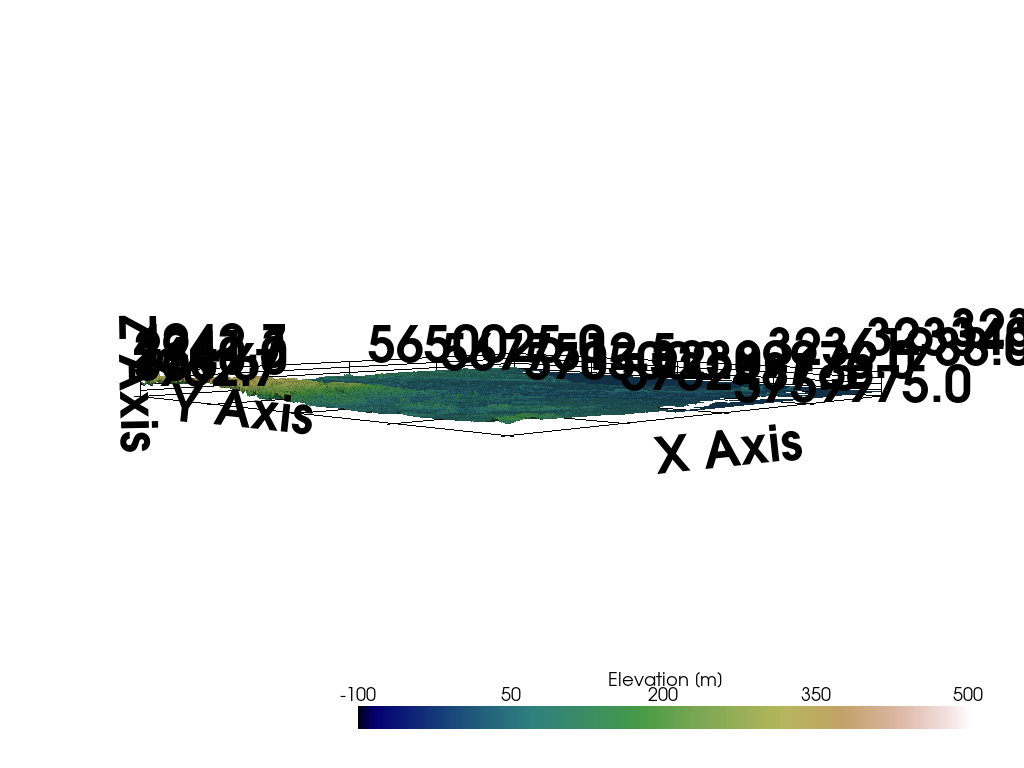

In [4]:
import pyvista as pv

sargs = dict(fmt="%.0f", color='black')

p = pv.Plotter(notebook=True)

# Adding DEM
p.add_mesh(topo, scalars='Elevation [m]', cmap='gist_earth', scalar_bar_args=sargs, clim=[-100, 500])

p.set_background('white')
p.show_grid(color='black')
p.set_scale(1,1,10)
p.show()

## Creating 3D Line of County Boundary

The boundary data was obtained from https://www.opengeodata.nrw.de/produkte/geobasis/vkg/dvg/dvg1/ and will be used under the same license as the Digital Elevation Model.

In [5]:
import geopandas as gpd

boundary = gpd.read_file(file_path + 'dvg1rbz_nw.shp')
boundary = boundary[boundary['GN'] == 'Düsseldorf']
boundary.head()

,ART,GN,KN,STAND,geometry
0,R,Düsseldorf,05100000,2020-03-04,"POLYGON ((295896.673 5747849.577, 295897.626 5..."


<Axes: >

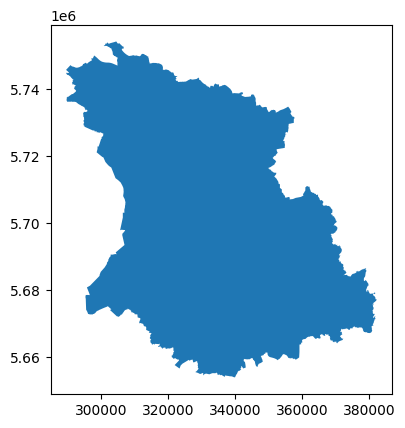

In [6]:
boundary.plot()

### Exploding Polygon to LineString

The first is to explode the polygon to a LineString using ``explode_polygons(..)``.

In [7]:
boundary_line = gg.vector.explode_polygons(gdf=boundary)
boundary_line

,ART,GN,KN,STAND,geometry
0,R,Düsseldorf,05100000,2020-03-04,"LINESTRING (295896.673 5747849.577, 295897.626..."


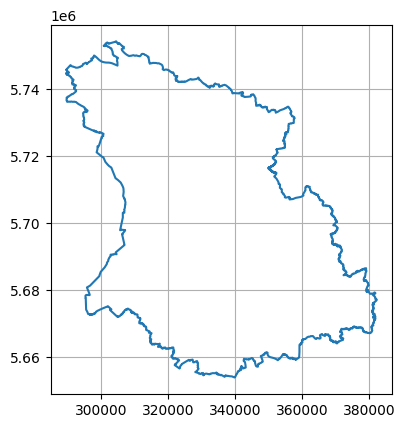

In [8]:
import matplotlib.pyplot as plt

boundary_line.plot()
plt.grid()

### Extracting vertices from line

The next step is to extract the vertices from this one line using ``extract_xyz(..)``. 

In [9]:
boundary_points = gg.vector.extract_xyz(gdf=boundary_line, dem=raster, target_crs='EPSG:4647')
boundary_points

,ART,GN,KN,STAND,geometry,X,Y,Z
0,R,Düsseldorf,05100000,2020-03-04,POINT (32295896.673 5747849.577),32295896.67,5747849.58,11.49
1,R,Düsseldorf,05100000,2020-03-04,POINT (32295897.626 5747850.839),32295897.63,5747850.84,11.56
2,R,Düsseldorf,05100000,2020-03-04,POINT (32295943.179 5747880.192),32295943.18,5747880.19,11.44
3,R,Düsseldorf,05100000,2020-03-04,POINT (32295959.070 5747891.749),32295959.07,5747891.75,11.70
4,R,Düsseldorf,05100000,2020-03-04,POINT (32295975.984 5747906.266),32295975.98,5747906.27,11.55
...,...,...,...,...,...,...,...,...
27446,R,Düsseldorf,05100000,2020-03-04,POINT (32295802.571 5747693.901),32295802.57,5747693.90,11.58
27447,R,Düsseldorf,05100000,2020-03-04,POINT (32295840.751 5747767.801),32295840.75,5747767.80,11.44
27448,R,Düsseldorf,05100000,2020-03-04,POINT (32295857.959 5747796.720),32295857.96,5747796.72,11.65
27449,R,Düsseldorf,05100000,2020-03-04,POINT (32295870.009 5747814.641),32295870.01,5747814.64,11.49


### Creating LineString with Z component

A LineString with a Z component can be created using ``create_linestring_from_xyz_points(..)``.

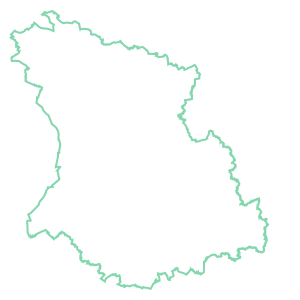

In [10]:
boundary_line_z = gg.vector.create_linestring_from_xyz_points(points=boundary_points)
boundary_line_z

### Creating GeoDataFrame from LineString 

In [11]:
gdf_boundary = gpd.GeoDataFrame(geometry=[boundary_line_z])
gdf_boundary

,geometry
0,"LINESTRING Z (32295896.673 5747849.577 11.490,..."


### Creating 3D Lines

The last step is to create the 3D lines and return the data as PyVista PolyData.


In [12]:
boundary_pv = gg.visualization.create_lines_3d_polydata(gdf=gdf_boundary)
boundary_pv['Label'] = ['Regierungsbezirk Dusseldorf']
boundary_pv

PolyData (0x1c825a43e80)
  N Cells:    1
  N Points:   27451
  N Strips:   0
  X Bounds:   3.229e+07, 3.238e+07
  Y Bounds:   5.654e+06, 5.754e+06
  Z Bounds:   -4.745e+01, 3.433e+02
  N Arrays:   1

## Creating 3D lines of Faults

The same workflow can be applied to a dataset with multiple LineStrings. In this case the faults that were mapped in the area. 

In [13]:
bbox = (32250000, 5650000, 32390000, 5760000)

In [14]:
faults = gpd.read_file(file_path + 'gg_nrw_geotekst_l.shp', bbox=bbox)
faults.head()

,OBJECTID_1,OBJECTID_2,Layer_Name,Quelle,ST_NAME,OBJECTID,Id,ssymbol_QB,ST_NR,ST_ART_ID,...,DIP_3D,STOE_UEB_3,STOE_TOP_H,STOE_BASIS,ST_ART_3D,Shape_Le_2,Versatz_TB,Doku_Versa,Shape_Le_3,geometry
0,52.00,52,Störung040_Quadrather Sprung_SW,Erft Scholle RWE Projekt 2015,Quadrather Sprung,0,0,NaN,0.00,0,...,62.50,regionale Bedeutung,DGM,Tertiaer_b/Praeperm_t/Karbon_t,NaN,9317.89,0.00,NaN,9317.89,"LINESTRING (32338164.037 5644376.205, 32338092..."
1,99.00,99,Störung067_Peringshofer Sprung 1_NE,Erft Scholle RWE Projekt 2015,Peringshofer Sprung,0,0,NaN,0.00,0,...,62.50,lokale Bedeutung,DGM,Tertiaer_b/Praeperm_t/Karbon_t,NaN,3304.34,0.00,NaN,3304.34,"LINESTRING (32332455.392 5650412.839, 32332407..."
2,100.00,100,Störung068_Sandberg Sprung_NE,Erft Scholle RWE Projekt 2015,Sandberg Sprung,0,0,NaN,0.00,0,...,62.50,überregionale Bedeutung,DGM,Tertiaer_b/Praeperm_t/Karbon_t,NaN,3242.54,0.00,NaN,3242.54,"LINESTRING (32331619.679 5651276.996, 32331513..."
3,101.00,101,Störung069_Bedburger Sprung_NE,Erft Scholle RWE Projekt 2015,Bedburger Sprung,0,0,NaN,0.00,0,...,62.50,lokale Bedeutung,DGM,Tertiaer_b/Praeperm_t/Karbon_t,NaN,6404.51,0.00,NaN,6404.51,"LINESTRING (32333471.001 5648319.956, 32333423..."
4,102.00,102,Störung070_Bedburger Sprung 1_NE,Erft Scholle RWE Projekt 2015,Bedburger Sprung,0,0,NaN,0.00,0,...,62.50,lokale Bedeutung,DGM,Tertiaer_b/Praeperm_t/Karbon_t,NaN,1656.99,0.00,NaN,1656.99,"LINESTRING (32332714.438 5649401.541, 32332618..."


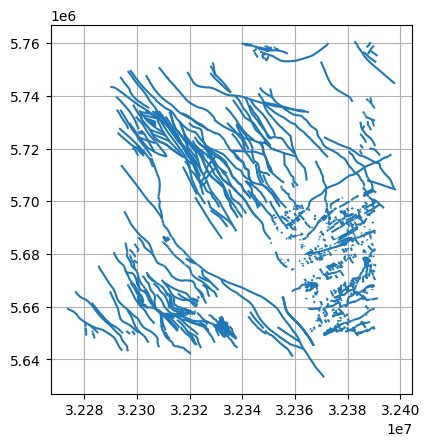

In [15]:
import matplotlib.pyplot as plt

faults.plot()
plt.grid()

### Extracting vertices from line

The vertices will be extracted from the lines again. Here, it is important to NOT reset the index of the resulting GeoDataFrame!

In [16]:
faults = faults[faults.is_valid]
faults = faults[~faults.is_empty]
faults = faults.explode().reset_index(drop=True)
faults_xyz = gg.vector.extract_xyz(gdf=faults, dem=raster, reset_index=False)
faults_xyz.head()

OBJECTID_1  OBJECTID_2                       Layer_Name   
0 0       52.00          52  Störung040_Quadrather Sprung_SW  \
  0       52.00          52  Störung040_Quadrather Sprung_SW   
  0       52.00          52  Störung040_Quadrather Sprung_SW   
  0       52.00          52  Störung040_Quadrather Sprung_SW   
  0       52.00          52  Störung040_Quadrather Sprung_SW   

                            Quelle            ST_NAME  OBJECTID  Id   
0 0  Erft Scholle RWE Projekt 2015  Quadrather Sprung         0   0  \
  0  Erft Scholle RWE Projekt 2015  Quadrather Sprung         0   0   
  0  Erft Scholle RWE Projekt 2015  Quadrather Sprung         0   0   
  0  Erft Scholle RWE Projekt 2015  Quadrather Sprung         0   0   
  0  Erft Scholle RWE Projekt 2015  Quadrather Sprung         0   0   

     ssymbol_QB  ST_NR  ST_ART_ID  ...                      STOE_BASIS   
0 0         NaN   0.00          0  ...  Tertiaer_b/Praeperm_t/Karbon_t  \
  0         NaN   0.00          0  ...  Tertiaer_b/Praeperm_t/Karbon_t   
  0         NaN   0.00          0  ...  Tertiaer_b/Praeperm_t/Karbon_t   
  0         NaN   0.00          0  ...  Tertiaer_b/Praeperm_t/Karbon_t   
  0         NaN   0.00          0  ...  Tertiaer_b/Praeperm_t/Karbon_t   

     ST_ART_3D  Shape_Le_2  Versatz_TB  Doku_Versa  Shape_Le_3   
0 0        NaN     9317.89        0.00         NaN     9317.89  \
  0        NaN     9317.89        0.00         NaN     9317.89   
  0        NaN     9317.89        0.00         NaN     9317.89   
  0        NaN     9317.89        0.00         NaN     9317.89   
  0        NaN     9317.89        0.00         NaN     9317.89   

                             geometry           X          Y       Z  
0 0  POINT (32338164.037 5644376.205) 32338164.04 5644376.20 9999.00  
  0  POINT (32338092.156 5644454.183) 32338092.16 5644454.18 9999.00  
  0  POINT (32338020.275 5644532.162) 32338020.28 5644532.16 9999.00  
  0  POINT (32337976.168 5644579.490) 32337976.17 5644579.49 9999.00  
  0  POINT (32337847.430 5644717.324) 32337847.43 5644717.32 9999.00  

[5 rows x 50 columns]

### Creating LineStrings with Z component

As before, LineStrings with Z components will be created. This time, the function ``create_linestrings_from_xyz_points(..)`` is used. 

In [17]:
faults_lines_z = gg.vector.create_linestrings_from_xyz_points(gdf=faults_xyz, groupby='OBJECTID_2', return_gdf=True)
faults_lines_z

,OBJECTID_1,OBJECTID_2,Layer_Name,Quelle,ST_NAME,OBJECTID,Id,ssymbol_QB,ST_NR,ST_ART_ID,...,DIP_3D,STOE_UEB_3,STOE_TOP_H,STOE_BASIS,ST_ART_3D,Shape_Le_2,Versatz_TB,Doku_Versa,Shape_Le_3,geometry
0,52.00,52,Störung040_Quadrather Sprung_SW,Erft Scholle RWE Projekt 2015,Quadrather Sprung,0,0,NaN,0.00,0,...,62.50,regionale Bedeutung,DGM,Tertiaer_b/Praeperm_t/Karbon_t,NaN,9317.89,0.00,NaN,9317.89,"LINESTRING Z (32332790.835 5650048.917 83.820,..."
1,99.00,99,Störung067_Peringshofer Sprung 1_NE,Erft Scholle RWE Projekt 2015,Peringshofer Sprung,0,0,NaN,0.00,0,...,62.50,lokale Bedeutung,DGM,Tertiaer_b/Praeperm_t/Karbon_t,NaN,3304.34,0.00,NaN,3304.34,"LINESTRING Z (32332455.392 5650412.839 69.640,..."
2,100.00,100,Störung068_Sandberg Sprung_NE,Erft Scholle RWE Projekt 2015,Sandberg Sprung,0,0,NaN,0.00,0,...,62.50,überregionale Bedeutung,DGM,Tertiaer_b/Praeperm_t/Karbon_t,NaN,3242.54,0.00,NaN,3242.54,"LINESTRING Z (32331619.679 5651276.996 54.820,..."
3,101.00,101,Störung069_Bedburger Sprung_NE,Erft Scholle RWE Projekt 2015,Bedburger Sprung,0,0,NaN,0.00,0,...,62.50,lokale Bedeutung,DGM,Tertiaer_b/Praeperm_t/Karbon_t,NaN,6404.51,0.00,NaN,6404.51,"LINESTRING Z (32331896.183 5650024.802 69.040,..."
4,102.00,102,Störung070_Bedburger Sprung 1_NE,Erft Scholle RWE Projekt 2015,Bedburger Sprung,0,0,NaN,0.00,0,...,62.50,lokale Bedeutung,DGM,Tertiaer_b/Praeperm_t/Karbon_t,NaN,1656.99,0.00,NaN,1656.99,"LINESTRING Z (32331991.560 5650081.463 69.630,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1510,13323.00,13324,NaN,3DLandesmodell,Hervester Sprung,0,0,NaN,0.00,0,...,79.00,überregionale Bedeutung,Oberkreide_b,Praeperm_t/Karbon_t,NaN,32201.82,0.00,NaN,32201.82,"LINESTRING Z (32372522.961 5716737.961 46.730,..."
1511,13324.00,13325,NaN,3DLandesmodell,Tertius Sprung,0,0,NaN,0.00,0,...,80.00,überregionale Bedeutung,Oberkreide_b,Praeperm_t/Karbon_t,NaN,45355.26,0.00,NaN,45355.26,"LINESTRING Z (32386330.289 5705646.290 88.140,..."
1512,13325.00,13326,NaN,3DLandesmodell,Rhader Stoerung,0,0,NaN,0.00,0,...,83.00,überregionale Bedeutung,Oberkreide_b,Praeperm_t/Karbon_t,NaN,50431.89,0.00,NaN,50431.89,"LINESTRING Z (32365258.965 5733746.961 52.790,..."
1513,13331.00,13332,NaN,isgk100,Bergische Überschiebung,0,0,NaN,0.00,0,...,80.00,lokale Bedeutung,DGM,NaN,Abschiebung,627.73,0.00,NaN,627.73,LINESTRING Z (32372730.326 5650769.467 181.760...


### Creating 3D Lines

The last step is to create the 3D lines and return the data as PyVista PolyData.


In [19]:
faults_pv = gg.visualization.create_lines_3d_polydata(gdf=faults_lines_z)
faults_pv

PolyData,Information
N Cells,1515
N Points,36539
N Strips,0
X Bounds,"3.228e+07, 3.239e+07"
Y Bounds,"5.650e+06, 5.760e+06"
Z Bounds,"-8.993e+01, 4.156e+02"
N Arrays,0


## Plotting the data on top of the DEM

C:\Users\ale93371\Anaconda3\envs\pygeomechanical\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


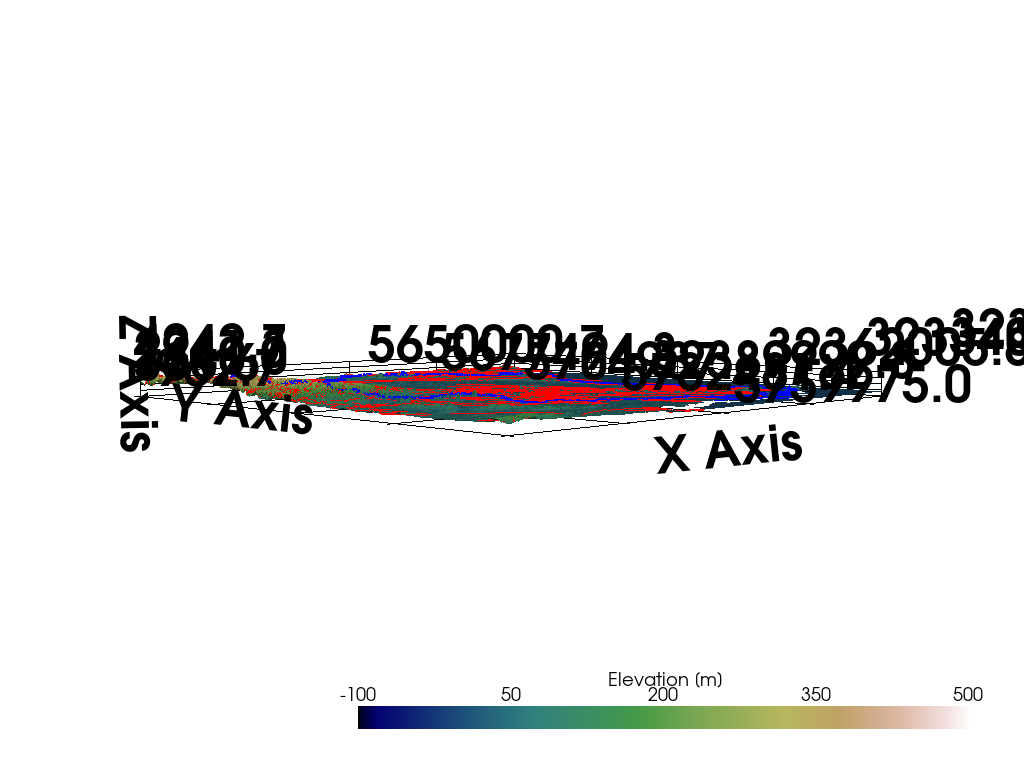

In [20]:
import pyvista as pv

sargs = dict(fmt="%.0f", color='black')

p = pv.Plotter(notebook=True)

# Adding DEM
p.add_mesh(topo, scalars='Elevation [m]', cmap='gist_earth', scalar_bar_args=sargs, clim=[-100, 500])

# Adding boundary
p.add_mesh(boundary_pv, color='blue', line_width=5)

# Adding faults
p.add_mesh(faults_pv,color='red', line_width=2)

p.set_background('white')
p.show_grid(color='black')
p.set_scale(1,1,10)
p.show()